# Classifiers in Sklearn

✅ При подборе гиперпараметров необходима устойчивая метрика, которая не будет прыгать в зависимости от перемешивания данных.<br> 
✅ Когда мы используем `X_trn, X_val, Y_trn, Y_val = train_test_split(X, Y, test_size=0.2)` - случайная (сравнительно небольшая) val-выборка <br>
✅ Поэтому мы используем cross_validate с достаточно большим cv ~ 100. Это стремтися к гребё

In [97]:
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt      
import seaborn as sn

from sklearn.datasets import make_moons
from   sklearn.model_selection import train_test_split, cross_validate, cross_val_score

#---------------------------------------------------------------------------------------

def generate_xor(num = 50):
    X1 = np.random.normal( [0.2,0.2], 0.1, (num,2)).clip(0,1);  Y1 = np.full((num,), 0)   
    X2 = np.random.normal( [0.8,0.2], 0.1, (num,2)).clip(0,1);  Y2 = np.full((num,), 1)   
    X3 = np.random.normal( [0.8,0.8], 0.1, (num,2)).clip(0,1);  Y3 = np.full((num,), 0)   
    X4 = np.random.normal( [0.2,0.8], 0.1, (num,2)).clip(0,1);  Y4 = np.full((num,), 1)   
    return np.concatenate([X1,X2,X3,X4], axis=0),  np.concatenate([Y1,Y2,Y3,Y4], axis=0)

#---------------------------------------------------------------------------------------

def two_blobs(num = 100):
    X1 = np.random.normal( [0.3,0.7], 0.2, (num,2)).clip(0,1);  Y1 = np.full((num,), 0)
    X2 = np.random.normal( [0.7,0.3], 0.2, (num,2)).clip(0,1);  Y2 = np.full((num,), 1)
    return np.concatenate([X1,X2], axis=0),  np.concatenate([Y1,Y2], axis=0)

#-------------------------------------------------------------------------------------    

def shuffle_data(X,Y):
    idx = np.random.permutation(len(Y)) 
    return X[idx], Y[idx]        
    
#---------------------------------------------------------------------------------------

def eval_model(clf, X,Y, cv=20, prob = True, mix=True, info=""):
    if mix:
        X, Y = shuffle_data(X,Y)
        
    tm1 = time.process_time() 
    res = cross_validate(clf, X, Y, cv=cv, return_train_score=True)            
    tm2 = time.process_time() 
    acc_tst, acc_trn = res['test_score'],  res['train_score']
    
    clf.fit(X,Y)
    probs = clf.predict_proba(X)  if prob else [[0, 0]]
    probs = np.max(probs, axis=1)
    
    print(f"val: {acc_tst.mean():.3f} ± {acc_tst.std():.3f} [{acc_tst.min():.3f} ... {acc_tst.max():.3f}]   trn: {acc_trn.mean():.3f} ± {acc_trn.std():.3f}  [{acc_trn.min():.3f} ... {acc_trn.max():.3f}]  probs: {probs.mean():.3f} ± {probs.std():.3f}    {(tm2-tm1)/cv:.2f}s   {info}")
    return acc_tst.mean(),  acc_trn.mean(), probs.mean()

#---------------------------------------------------------------------------------------

def confusion(clf, X, Y):    
    
    cm = confusion_matrix(Y, clf.predict(X), normalize='true')
    
    plt.figure(figsize = (2,2), facecolor="w")
    sn.heatmap(cm, annot=True, cbar=False, annot_kws={"size": 16})
    plt.show()
    return cm
    
#---------------------------------------------------------------------------------------
    
def plot_data(X, Y, lim=(0.,1.), clf = None, num = 100, prob = True, title=""):                

    plt.figure (figsize=(4, 4), facecolor ='w')                                 
    
    if clf is not None:   
        x1 = np.linspace(lim[0], lim[1], num, dtype=np.float32)
        x2 = np.linspace(lim[0], lim[1], num, dtype=np.float32)
        x1, x2 =  np.meshgrid(x1, x2)            
        inp = np.c_[x1.ravel(), x2.ravel()]
        if prob:
            prob = clf.predict_proba(inp)[:,1].reshape(x1.shape)
            plt.imshow(prob, extent=[lim[0], lim[1], lim[0], lim[1]],  origin='lower', cmap='bwr', alpha=0.3)
            
            label = clf.predict(inp).reshape(x1.shape) 
            plt.contour(x1, x2, label, cmap='gray')                
        else:        
            label = clf.predict(inp).reshape(x1.shape) 
            plt.contourf(x1, x2, label, alpha=0.3, cmap='bwr')                
    
    plt.scatter(X[:,0], X[:,1], c=Y,  s=5, cmap='bwr')        
    plt.xlim(0, 1)
    plt.ylim(0, 1);
    plt.title(title)
    plt.show()                                                  

## Create Data

In [202]:
X, Y = generate_xor(num = 150)
#X, Y = two_blobs(num = 250)
#X, Y = make_moons(n_samples=500, noise=0.2, random_state=42)  # 

X = (X - X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))
print(X.shape, Y.shape)
#plot_data(X,Y)

(600, 2) (600,)


## LogisticRegression

val: 0.440 ± 0.203 [0.000 ... 1.000]   trn: 0.507 ± 0.008  [0.492 ... 0.524]  probs: 0.505 ± 0.003    0.01s


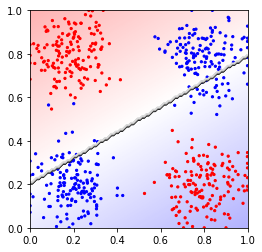

In [203]:
from sklearn.linear_model    import LogisticRegression

clf = LogisticRegression(C=1)   # C - inverse of regularization strength (smaller values specify stronger regularization)

eval_model(clf, X,Y , cv=100)
plot_data(X, Y, clf = clf)     

## KNeighbors

val: 0.974 ± 0.067 [0.800 ... 1.000]   trn: 0.976 ± 0.001  [0.974 ... 0.980]  probs: 0.968 ± 0.077    0.01s


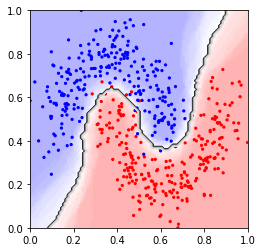

In [118]:
from sklearn.neighbors       import KNeighborsClassifier

class CFG:        
    n_neighbors = 20   

clf = KNeighborsClassifier(n_neighbors = CFG.n_neighbors)

eval_model(clf, X,Y, cv = 100)
plot_data(X, Y, clf = clf)  

## SVM

val: 0.974 ± 0.067 [0.800 ... 1.000]   trn: 0.974 ± 0.001  [0.972 ... 0.976]  probs: 0.000 ± 0.000    0.00s


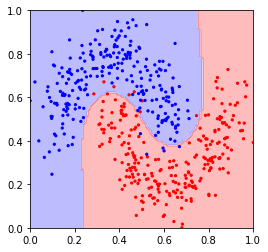

In [123]:
from sklearn.svm import LinearSVC, SVC, NuSVC

clf = SVC()

eval_model(clf, X,Y, cv = 100, prob = False)
plot_data(X, Y, clf = clf, prob = False)

## DecisionTree

✅ Деревья решений лучше других методов, когда расстояние между точками в прострастве прихнаков особого смысла не имеет (разделение только по одному признаку).<br>
✅ Деревья не требуют масштабирования или центрирования признаков.<br>

val: 0.976 ± 0.071 [0.600 ... 1.000]   trn: 0.986 ± 0.001  [0.986 ... 0.990]  probs: 0.986 ± 0.070    0.00s
depth: 6


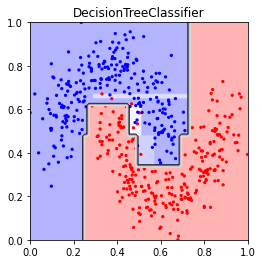

In [152]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

class CFG:        
    min_samples_leaf = 5       # Def:1
    min_samples_split= 2       # Def:2
    max_depth        = None    # Def:None

clf = DecisionTreeClassifier(max_depth=CFG.max_depth, min_samples_split=CFG.min_samples_split, min_samples_leaf=CFG.min_samples_leaf)
#clf = DecisionTreeClassifier()

eval_model(clf, X,Y, cv = 100)
print(f"depth: {clf.get_depth()}")
plot_data(X, Y, clf = clf, title="DecisionTreeClassifier")     

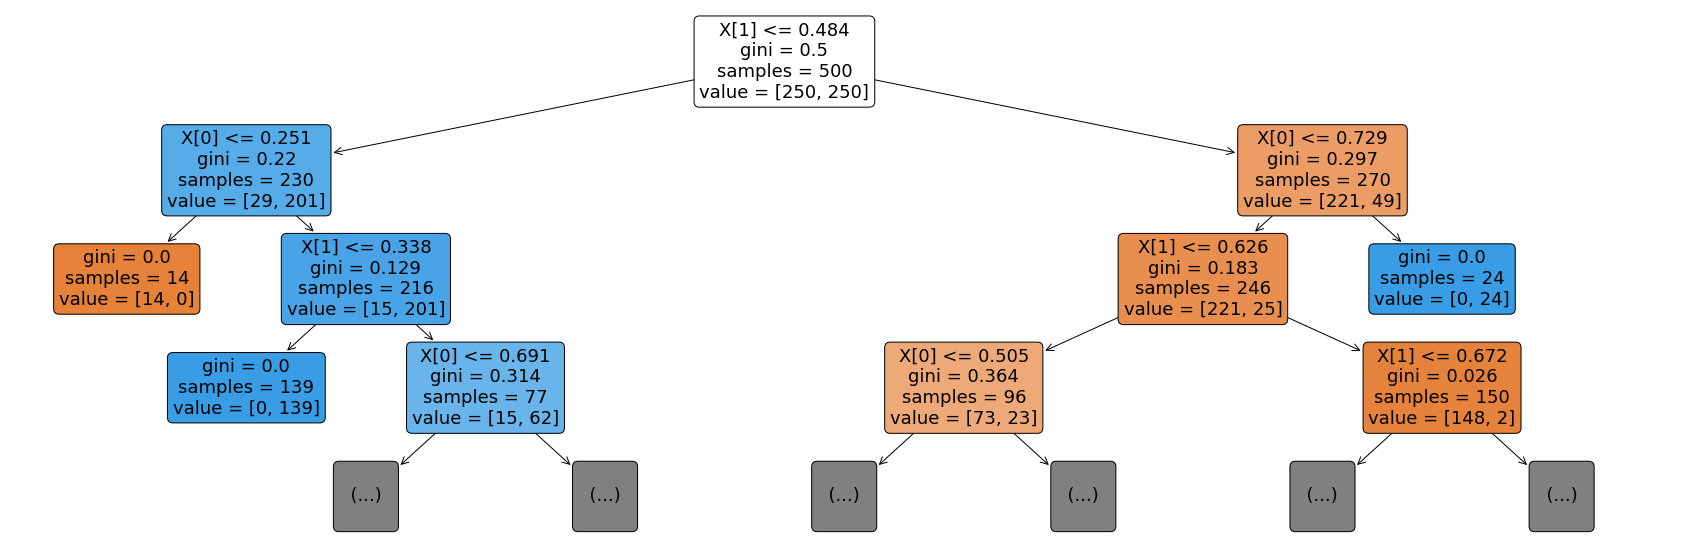

In [155]:
clf = DecisionTreeClassifier()
clf.fit(X,Y)
plt.figure(figsize=(30, 10), facecolor ='w')     
tree.plot_tree(clf,   max_depth=3,  filled=True, fontsize=18, rounded=True) # feature_names=COLUMNS,
plt.show()

##  RandomForest

val: 0.922 ± 0.116 [0.600 ... 1.000]   trn: 0.942 ± 0.007  [0.925 ... 0.958]  probs: 0.873 ± 0.131    0.07s


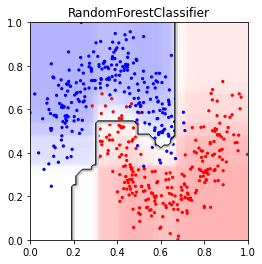

In [158]:
from sklearn.ensemble import RandomForestClassifier

class CFG:    
    n_estimators     = 100
    min_samples_leaf = 20
    max_depth        = None
    
clf = RandomForestClassifier(n_estimators=CFG.n_estimators, max_depth=CFG.max_depth, min_samples_leaf=CFG.min_samples_leaf)
#clf = DecisionTreeClassifier()

eval_model(clf, X,Y, cv = 100)
plot_data(X, Y, clf = clf, title="RandomForestClassifier")         

# Ансамбли моделей

## Bag Ensemble

val: 0.930 ± 0.111 [0.600 ... 1.000]   trn: 0.943 ± 0.007  [0.931 ... 0.966]  probs: 0.869 ± 0.139    0.07s


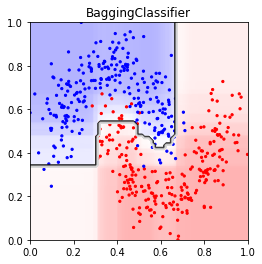

In [160]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(LogisticRegression(max_iter=1000),  
                        max_samples=0.5, max_features=0.8)

eval_model(clf, X,Y, cv = 100)
plot_data(X, Y, clf = clf, title="BaggingClassifier")         

## AdaBoost

## GradientBoostingClassifier

val: 0.964 ± 0.091 [0.400 ... 1.000]   trn: 1.000 ± 0.000  [1.000 ... 1.000]  probs: 1.000 ± 0.000    0.12s


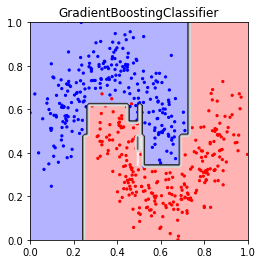

In [161]:
from sklearn.ensemble import GradientBoostingClassifier

class CFG:    
    n_estimators = 300
    max_depth    = 30

clf = GradientBoostingClassifier(n_estimators=CFG.n_estimators, max_depth=CFG.max_depth, random_state=0)

eval_model(clf, X,Y, cv = 100)
plot_data(X, Y, clf = clf, title="GradientBoostingClassifier")     

## CatBoost

val: 0.974 ± 0.078 [0.600 ... 1.000]   trn: 0.997 ± 0.001  [0.996 ... 1.000]  probs: 0.984 ± 0.054    3.66s


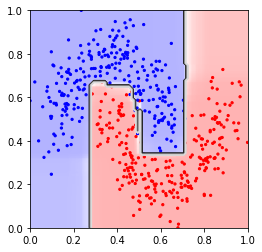

In [163]:
from catboost import CatBoostClassifier

class CFG: # https://docs.aws.amazon.com/sagemaker/latest/dg/catboost-tuning.html 
    max_depth       = 10       # Valid:int[1,16], Def:6     Grid:[4,10]        > Depth of the tree
    l2_leaf_reg     = 100       # Valid:int>0,    Def:3     Grid:[2,10]        > Coefficient for the L2 regularization term of the cost function.
    random_strength = 1       # Valid:float>0     Def:1     Grid:[0,10]        > The amount of randomness to use for scoring splits when the tree structure is selected. Use this parameter to avoid overfitting the model.
    learning_rate   = 0.1     # Valid:float[0,1]  Def:0.009 Grid:[0.001, 0.01] > The rate at which the model weights are updated after working through each batch of training examples (0,1) 
    iterations      = 500     #                   Def:500   Grid:[]            > The maximum number of trees that can be built    

clf = CatBoostClassifier(iterations=CFG.iterations, learning_rate=CFG.learning_rate, l2_leaf_reg=CFG.l2_leaf_reg, random_strength=CFG.random_strength, verbose=0)        
eval_model(clf, X,Y, cv = 100)
plot_data(X, Y, clf = clf)     

In [164]:
%%time
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
estimators = [    
    ('cat1',   CatBoostClassifier(max_depth = 10, l2_leaf_reg=100, random_strength=1, iterations=500, learning_rate=0.1, verbose=0, random_seed=1) ),
    ('cat2',   CatBoostClassifier(max_depth = 10, l2_leaf_reg=100, random_strength=1, iterations=500, learning_rate=0.1, verbose=0, random_seed=2) ),
    ('cat3',   CatBoostClassifier(max_depth = 10, l2_leaf_reg=100, random_strength=1, iterations=500, learning_rate=0.1, verbose=0, random_seed=3) ),    
    ('cat4',   CatBoostClassifier(max_depth = 10, l2_leaf_reg=100, random_strength=1, iterations=500, learning_rate=0.1, verbose=0, random_seed=4) ),    
    ('cat5',   CatBoostClassifier(max_depth = 10, l2_leaf_reg=100, random_strength=1, iterations=500, learning_rate=0.1, verbose=0, random_seed=5) ),    
]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression() )  # SVC()

eval_model(clf, X,Y, cv = 100)
plot_data(X, Y, clf = clf)     

#clf.fit(X, Y)
#plot_data(X, Y, clf = clf) 
#_,_,_ = eval_model(clf, X,Y, cv=20, info="StackingClassifier", prob=False)

"""
for i in range(3):
    X_trn, X_val, Y_trn, Y_val = train_test_split(X, Y, test_size=0.2) # random_state=42
    clf.fit(X_trn, Y_trn)
    print(f"val:{clf.score(X_val, Y_val):.4f},  trn:{clf.score(X_trn, Y_trn):.4f}")
    plot_data(X, Y, clf = clf) 
"""    

KeyboardInterrupt: 

## LightGBM

val: 0.982 ± 0.015    trn: 1.000 ± 0.000  probs: 0.991 ± 0.005


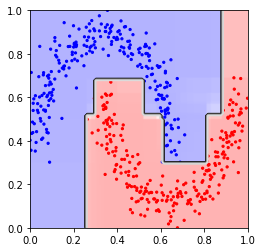

In [233]:
import lightgbm as lgb

class CFG:
    method          = 'lgb'          #
    tree_type       = 'dart'         # Def:'gbdt'   Val:('dart' 'gbdt' 'goss')
    
    n_estimators    = 200            # Def:100
    learning_rate   = 0.1            # Def:0.1
            
    # Это очень важный параметр для предотвращения чрезмерной подгонки в листовом дереве.
    # Его оптимальное значение зависит от количества обучающих выборок и num_leaves
    #min_data_in_leaf = 100
    
    max_depth     = -1
    
    ensemble      = 13
    
clf = lgb.LGBMClassifier(boosting_type=CFG.tree_type,  learning_rate=CFG.learning_rate)
eval_model(clf, X,Y)
plot_data(X, Y, clf = clf)     

## PlaneTree

(600, 2) 0.5 306 294
(306, 2) 0.49019607843137253 145 161
(145, 2) 0.020689655172413793 127 18
(161, 2) 0.9130434782608695 14 147
(294, 2) 0.5102040816326531 131 163
(131, 2) 0.015267175572519083 121 10
(163, 2) 0.9079754601226994 15 148
(148, 2) 0.9932432432432432 18 130
depth 4


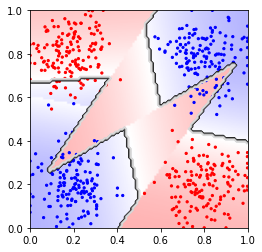

In [208]:
from sklearn.linear_model    import LogisticRegression

class PlaneTreeNode:
    def __init__(self, min_samples = 5, max_depth = 100, depth = 1):
        self.min_samples = min_samples
        self.max_depth   = max_depth
        self.depth = depth + 1
        self.clf   = LogisticRegression(class_weight='balanced')          
        self.nodes = [None, None]
              
    def fit(self, X,Y):     
        eps = 1e-3
        if Y.mean() < eps or Y.mean() > 1-eps or self.depth > self.max_depth:
            return None
        
        self.clf.fit(X,Y)        
        Y_pred = self.clf.predict(X)                
        
        side0, side1 = (Y_pred == 0), (Y_pred == 1)
        X0, Y0 = X[side0], Y[side0]
        X1, Y1 = X[side1], Y[side1] 
        
        print(X.shape, Y.mean(), len(Y0), len(Y1))
                        
        if len(Y0) > self.min_samples and len(Y1) > 0:            
            self.nodes[0] = PlaneTreeNode(self.min_samples, self.max_depth, depth=self.depth).fit(X0,Y0)
            
        if len(Y1) > self.min_samples and len(Y0) > 0:                        
            self.nodes[1] = PlaneTreeNode(self.min_samples, self.max_depth, depth=self.depth).fit(X1,Y1)
            
        return self
            
    def predict_proba(self, X):
        probs = np.zeros((X.shape[0], 2))
        for i,xi in enumerate(X):
            x = xi.reshape(1,-1)
            s = self.clf.predict(x)[0]          
            clf = self.nodes[s]
            if clf is None:
                p = self.clf.predict_proba(x)
            else:
                p = clf.predict_proba(x)
            probs[i,0] = p[0,0]
            probs[i,1] = p[0,1]
        return probs
    
    def get_depth(self):        
        d0 = 0 if self.nodes[0] is None else self.nodes[0].get_depth()
        d1 = 0 if self.nodes[1] is None else self.nodes[1].get_depth()
        return 1 + max(d0,d1)
        
#------------------------------------------------------------------------

class PlaneTree:
    def __init__(self, min_samples = 5, max_depth = 100):
        self.min_samples = min_samples
        self.max_depth   = max_depth
        self.root = None
    
    def fit(self, X,Y):
        self.root = PlaneTreeNode(self.min_samples, self.max_depth)
        self.root.fit(X,Y)
        return self
    
    def predict(self, X):
        if self.root is not None:
            probs = self.root.predict_proba(X)
            return np.argmax(probs, axis=1)

    def predict_proba(self, X):
        if self.root is not None:
            return self.root.predict_proba(X)
    
    def score(self, X,Y):
        Y_pred = self.predict(X)
        return (Y_pred == Y) .mean()
    
    def get_depth(self):
        return self.root.get_depth()

clf = PlaneTree(50, 10)
#eval_model(clf, X,Y)
clf.fit(X,Y)
print("depth", clf.get_depth())
plot_data(X, Y, clf = clf)     